Ingest post-processed Baysor results into Scanpy, cluster cells, compute marker genes, and write to h5ad file.

In [15]:
import scanpy as sc
import pandas as pd
import numpy as np

baysor_mtx is the folder created by 10X's post-processing script: https://github.com/NUPulmonary/utils/blob/master/spatial/map_transcripts.py. It should contain the expression matrix, the features file, and the barcodes file.

In [2]:
adata = sc.read_10x_mtx('/projects/b1038/Pulmonary/lcusick/projects/baysor/mlung-test/baysor_mtx')

In [4]:
adata.obs["sample"] = 'baysor'

In [6]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

Filter cells without 15 genes and filter genes that do not exist in at least 3 cells.

In [26]:
sc.pp.filter_cells(adata, min_genes=15)
sc.pp.filter_genes(adata, min_cells=3)

In [33]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()

In [27]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

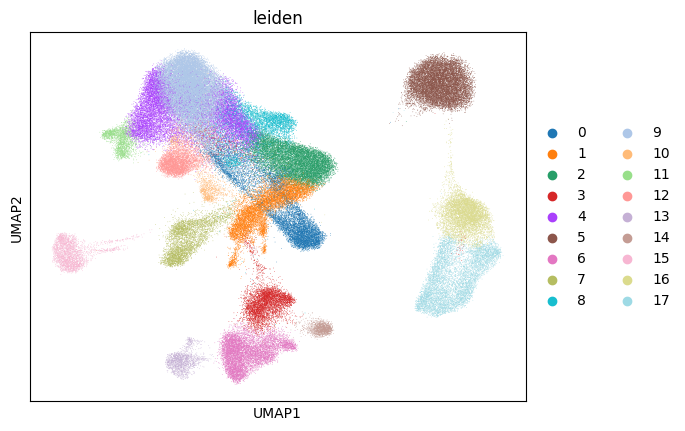

In [28]:
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=1)
sc.pl.umap(adata, color=["leiden"], wspace=1)

This is a modified version of the get_markers function that Nik wrote--it works with newest version of NumPy.

In [29]:
def get_markers(
    anndata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    markers = pd.concat([
        pd.DataFrame(anndata.uns[key]["names"]).melt(),
        pd.DataFrame(anndata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(anndata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers['pct.1'] = np.nan
    markers['pct.2'] = np.nan

    for cluster in markers.cluster.unique():
        cells = anndata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        in_cluster_selector = np.squeeze(np.asarray(in_cluster_selector))
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(anndata[cells, genes].X > 0, axis=0) / cells.sum()

        test = markers.loc[in_cluster_selector==True,]
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster.A1


        other_cells = anndata.obs[groupby] != cluster
        other_clusters = np.sum(anndata.raw[other_cells, genes].X > 0, axis=0) / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters.A1

    return markers

In [30]:
sc.tl.rank_genes_groups(adata, "leiden", layer='normalized', use_raw=False, method="wilcoxon", n_genes=200)
markers = get_markers(adata, "leiden")

Write adata object, markers csv, and metadata csv.

In [34]:
adata.write("/projects/b1038/Pulmonary/lcusick/projects/baysor/mlung-test/6448-1.h5ad")
markers.to_csv("/projects/b1038/Pulmonary/lcusick/projects/baysor/mlung-test/6448-1-markers.csv", index=False)
adata.obs.to_csv("/projects/b1038/Pulmonary/lcusick/projects/baysor/mlung-test/6448-1-metadata.csv")